In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import datetime as dt
import urllib
import requests as req
from bs4 import BeautifulSoup
import json

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Main dataset viewing

In [2]:
mbti = pd.read_csv('mbti_1.csv')
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
mbti.isnull().sum()

type     0
posts    0
dtype: int64

In [4]:
mbti.shape

(8675, 2)

In [45]:
mbti.iloc[3,1]

"'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub,   Long time no see.  Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences, like everything in humanity.|||Draco Malfoy also. I'd say he's either 358 or 368.|||I'm either 358 or 385, though in which stacking to me is a somewhat arbitrary distinction to make as I believe that the core indicates primary motivation and has a hand in every action. Therefore, a...|||I'm not particularly introverted or extraverted, personally. That said, I would say I'm somewhat unphased by either social interactions or being alone. What I'd say I crave more so than anything is...|||Dear Type 9 INFP,  Your absolute admiration of me is refreshing. You're a great girlfriend and I wish we both 

In [46]:
mbti['post_list'] = mbti.posts.apply(lambda x: x.split('|||'))
mbti.head()

,type,posts,post_list
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"['http://www.youtube.com/watch?v=qsXHcwe3krw, ..."
1,ENTP,'I'm finding the lack of me in these posts ver...,['I'm finding the lack of me in these posts ve...
2,INTP,'Good one _____ https://www.youtube.com/wat...,['Good one _____ https://www.youtube.com/wa...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","['Dear INTP, I enjoyed our conversation the ..."
4,ENTJ,'You're fired.|||That's another silly misconce...,"['You're fired., That's another silly misconce..."


In [12]:
def funkfunk(x):
    """
    RUN ONLY ONCE
    Removes the pesky single quote sign that somehow still remains after splitting them into a list.
    It technically returns nothing.
    """
    if re.match("'",x[0]):
        x[0] = x[0][1:]
    if re.match("'",x[-1][::-1]):
        x[-1] = x[-1][:-1]
    

mbti['post_list'].apply(funkfunk)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
8645    None
8646    None
8647    None
8648    None
8649    None
8650    None
8651    None
8652    None
8653    None
8654    None
8655    None
8656    None
8657    None
8658    None
8659    None
8660    None
8661    None
8662    None
8663    None
8664    None
8665    None
8666    None
8667    None
8668    None
8669    None
8670    None
8671    None
8672    None
8673    None
8674    None
Name: post_list, Length: 8675, dtype: object

In [47]:
mbti['post_list'][5]

["'18/37 @.@",
 'Science  is not perfect. No scientist claims that it is, or that scientific  information will not be revised as we discover new things.  Rational  thinking has been very useful to our society....',
 "INFP- Edgar Allen Poe was an INFP and he's in your siggy.",
 "People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...",
 'Lets get this party started  66314',
 'I did not say it disproved God. I merely said that I found such methods disturbing. Although, it does bring up certain questions. God is in control of the universe, and the governments of the world,...',
 'Surprisingly, I could not find a thread about this on perc even with Google. So, here you go.  Watch Jesus Camp online - Watch Movies Online, Full Movies, Download  I was disturbed watching this...',
 "A metaphysical gun (Hell) held to someone's head can be just as effecti

In [103]:
mbti.isnull().sum()

type         0
posts        0
post_list    0
dtype: int64

In [104]:
mbti.dtypes

type         object
posts        object
post_list    object
dtype: object

In [105]:
#Create new dataframe to keep and generate features
mbtilist = pd.DataFrame(mbti['post_list'])
mbtilist.head()

,post_list
0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,[I'm finding the lack of me in these posts ver...
2,[Good one _____ https://www.youtube.com/wat...
3,"[Dear INTP, I enjoyed our conversation the o..."
4,"[You're fired., That's another silly misconcep..."


In [106]:
#test data using part
part = mbtilist.iloc[0:5,:]
part.head()

,post_list
0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,[I'm finding the lack of me in these posts ver...
2,[Good one _____ https://www.youtube.com/wat...
3,"[Dear INTP, I enjoyed our conversation the o..."
4,"[You're fired., That's another silly misconcep..."


### 1st iteration - Perform link extraction

In [107]:
def extractions(x, string):
    """
    Input:
    x = A list containing sentences
    string = regular expression that will match each word
    
    Output:
    lis = List of weblinks
    lis2 = List of 'words only' posts

    How the function works:

    While iterating per item (containing a sentence) in a list, the sentence is split into individual words separated by spaces.
    An input string containing a regular expression will be passed inside as part of the function.
    Iterating through each word, if the word matches the regular expression, it will be added into the new list.
    The new list will hence be collecting all the re matched words that came from the input list with the chunk of sentences.
    This function returns the new list.
    
    2nd update: I also needed a 'words only' list, and since getting the words only is just the 'else' process of getting
    links...
    """
    lis=[]
    lis2 = []
    for line in x[0]:
        lin = line.split()
        sstring = re.compile(string, flags=re.M)
        lis_temp =[]
        for l in lin:
            if sstring.search(l):
                lis.append(sstring.search(l).group(0))
            else:
                lis_temp.append(l)
        lis_string = ' '.join(lis_temp)
        lis2.append(lis_string)
    return lis, lis2

In [109]:
# item_x = part.apply(extractions, string='http.*',axis=1)
# part['weblink'] = [x[0] for x in item_x]
# part['words_only'] = [x[1] for x in item_x]

C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
#Compile list of links into main MBTI dataframe from successful code run
#When functions have failed me in multiple assignments I have to take things into my own hands (via list compre)
item_x = mbtilist.apply(extractions, string='http.*',axis=1)
mbtilist['weblink'] = [x[0] for x in item_x]
mbtilist['words_only'] = [x[1] for x in item_x]

In [112]:
def onelvl_extract(x, string):
    """
    Input:
    x = A list of words
    string = regular expression in string form

    How the function works:

    Iterating through each word, if the word matches the regular expression, it will be added into the new list.
    The new list will hence be collecting all the re matched words that came from the input list with the chunk of sentences.
    This function returns the new list.
    """

    lis=[]
    sstring = re.compile(string, flags=re.M)
    for line in x:
        if sstring.search(line):
            lis.append(sstring.search(line).group(0))
    return lis

In [17]:
# #reinitialize part
# part = mbtilist.iloc[0:5,:]
# part.head()

In [18]:
# partchunk1 = ''.join(part.weblink.apply(onelvl_extract, string='http.*(?=https?:)')[1])

In [19]:
# partchunk1

In [20]:
# wholechunk1 = part.weblink[1]

In [21]:
# wholechunk1

In [22]:
# littlechunk1 = ''.join([i for i in wholechunk1 if partchunk1 in i])

In [23]:
# print littlechunk1

In [24]:
# littlechunk1[len(partchunk1):]

In [113]:
def eliminate_httpdup(x):
    
    """
    Input = A list containing URLs

    How this function works:
    
    Some URLs that have been extracted happen to be concatenated successively without any separator in between.
    For example, a URL containing the following 'https://www.youtu.be/blahblahhttp://neninenipoopoo...'
    The function iterates through the URLs, identify the URL of the above kind then separates them.
    After separation, the concatenated string is then removed and the two separated URLs are added into the list.
    
    End result: 'https://www.youtu.be/blahblah' 'http://neninenipoopoo...'
    
    Additionally, there are also URLs which are incomplete i.e. 'http://',
    we will check both of the processed ones and drop them accordingly.
    
    This function returns the new list after the processing.
    Unfortunately there may exist multiple (more than 2) concatenated URLs and I still do not yet have the brain to process
    how to do that in one go, so this particular function got to be run multiple times.
    """
    
    wholechunk = list(x) #Must indicate as list, otherwise whatever happens to wholechunk will also happen to x :X
    for line in x:
        if re.match('http.*(?=https?:)', line):
            partchunk = re.match('http.*(?=https?:)', line).group(0)
            secondchunk = line[len(partchunk):]
            wholechunk.remove(line)
            if re.match('https?://.*\.[\w\d].*', partchunk):
                wholechunk.append(partchunk)
            if re.match('https?://.*\.[\w\d].*', secondchunk):
                wholechunk.append(secondchunk)
    return wholechunk
            

In [114]:
def sumall(x):
    return sum(x.apply(len))

In [27]:
# part['weblink'].apply(eliminate_httpdup)

In [28]:
# part['weblink1'] = part['weblink'].apply(eliminate_httpdup)

In [29]:
# #They are similar because its inplace and I don't know how!!!
# #Update: I think I fixed it!
# sumall(part['weblink'])

In [30]:
# sumall(part['weblink1'])

In [31]:
# sumall(mbtilist['weblink'])

In [115]:
#Its inplace by default, damnit
#Update: not anymore!

mbtilist['weblink1'] = mbtilist['weblink'].apply(eliminate_httpdup)
a = 0
count = 0
while a != sumall(mbtilist['weblink1']):
    a = sumall(mbtilist['weblink1'])
    print "No. links:", a
    mbtilist['weblink1'] = mbtilist['weblink1'].apply(eliminate_httpdup)
    count += 1
print count

No. links: 28556
No. links: 28569
No. links: 28573
No. links: 28575
No. links: 28576
5


### Extract website type

In [34]:
# #reinitialize part
# part = mbtilist.iloc[0:50,:]
# part.head()

In [35]:
# part['image'] = part['weblink1'].apply(onelvl_extract, string=r'.*\.(jpg|png|jpeg|gif).*|.*img.*|.*image.*')
# for partie in part['image']:
#     print "_________________________________________________________________________"
#     for i in partie:
#         print i
        

In [36]:
# for partie in part['weblink1']:
#     print "_________________________________________________________________________"
#     for i in partie:
#         print i

In [37]:
# #Try getting only the base url
# for partie in part['weblink1'].apply(onelvl_extract, string=r'(?=https?://)(.*)(?=/.*)')[0]:
#     print partie

In [38]:
# #Get videos
# part['video_link'] = part['weblink1'].apply(onelvl_extract, string=r'https?://.*youtu.*|http.*vimeo.*')

In [116]:
mbtilist.head()

,post_list,weblink,words_only,weblink1
0,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...","[http://www.youtube.com/watch?v=qsXHcwe3krw, h...","[, , enfp and intj moments sportscenter not to...","[http://www.youtube.com/watch?v=qsXHcwe3krw, h..."
1,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...
2,[Good one _____ https://www.youtube.com/wat...,"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[Good one _____, Of course, to which I say I k...","[https://www.youtube.com/watch?v=fHiGbolFFGw, ..."
3,"[Dear INTP, I enjoyed our conversation the o...","[https://www.youtube.com/watch?v=uelHwf8o7_U, ...","[Dear INTP, I enjoyed our conversation the oth...","[https://www.youtube.com/watch?v=uelHwf8o7_U, ..."
4,"[You're fired., That's another silly misconcep...","[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...","[You're fired., That's another silly misconcep...","[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ..."


In [117]:
#Get rest of the links
def happyfunc(x):
    """
    x: DataFrame row containing the total weblink plus the video and image link list
    This function removes the video and image urls from the weblink list and returns a new list.    
    """
    
    newlist = list(x[3])
    if x[4]:
        for img in x[4]:
            try:
                newlist.remove(img)
            except:
                print "WHUT"
                print img
                continue
    if x[5]:
        for you in x[5]:
            try:
                newlist.remove(you)
            except:
                print "WHUT"
                print you
                continue
    return newlist

In [118]:
# part['otherlink'] = part.apply(happyfunc, axis=1)

In [119]:
# for line in part['otherlink']:
#     print "______________________________________________"
#     for i in line:
#         print i

###### Get counts

In [120]:
# part['n_video'] = part['video_link'].apply(len)
# part['n_links'] = part['weblink1'].apply(len)
# part['n_image'] = part['image'].apply(len)

In [121]:
# part.head()

###### Videos

In [132]:
#Get youtube titles
def get_title(url):
    """
    url: URL of course!
    Fun times ahead!
    
    This function will specially take in the video URLs and return the title
    
    """
    try:
        html = req.get(url, timeout=1).text
        soup = BeautifulSoup(html, 'html.parser')
    except:
        return None
    title=None
    if "youtu" in url:
        title = re.match(r'<.+>(.*) - YouTube.*<.+>', str(soup.title))
    elif "vimeo" in url:
        title = re.match(r'<.+>(.*)<.+>', str(soup.h1))
    if title:
        print title.group(1)
        return title.group(1)
    else:
        return None
    

def insertlist(x):
    """
    Ok this function simply iterates through a list and applies the function to each link, then append to a new list
    if not None.
    """
    newlist=[]
    for url in x:
        y = get_title(url)
        if y is not None:
            newlist.append(y)
    return newlist

In [45]:
# part['video_title'] = part['video_link'].apply(insertlist)

In [46]:
#Classify other websites
# webclassifier = pd.read_csv('webcat.csv', header=None, names=['number','webpage','category'])
# webclassifier.head()

In [47]:
#webclassifier.shape

In [48]:
#webclassifier.isnull().sum()

In [49]:
#webclassifier.dropna(inplace=True)

In [50]:
#webclassifier.isnull().sum()

In [51]:
#webclassifier['category'].value_counts()

In [52]:
# def matchkeyword(x):
#     try:
#         worde =  re.match(r'.*www.facebook.*',str(x))
#     except:
#         return None
#     if worde:
#         print worde.group(0)
#     else:
#         return None

I'll try that another time.

In [53]:
#Other features to come soon

###### Images

In [54]:
#Still figuring out the google part, stay tuned!

##### Run webpage code in mbtilist

In [123]:
mbtilist['image'] = mbtilist['weblink1'].apply(onelvl_extract, string=r'.*\.(jpg|png|jpeg|gif).*|.*img.*|.*image.*')

In [124]:
mbtilist['video_link'] = mbtilist['weblink1'].apply(onelvl_extract, string=r'https?://.*youtu.*|http.*vimeo.*')

In [125]:
mbtilist['otherlink'] = mbtilist.apply(happyfunc, axis=1)

WHUT
http://b.vimeocdn.com/ps/187/573/1875738_300.jpg
WHUT
https://www.youtube.com/watch?v=eimgRedLkkU


In [126]:
mbtilist['n_video'] = mbtilist['video_link'].apply(len)
mbtilist['n_links'] = mbtilist['weblink1'].apply(len)
mbtilist['n_image'] = mbtilist['image'].apply(len)
mbtilist['n_otherlink'] = mbtilist['n_links']-mbtilist['n_image']-mbtilist['n_video']

In [133]:
#This code will take a LOOOOOOOOONGGGG while
mbtilist['video_title'] = mbtilist['video_link'].apply(insertlist)

FLYING IN MY PJs - [Living In Alaska 256]
ENFP and INTJ Morning Moment
ESPN SportsCenter's Not Top Ten - 12-06-13
Jinkis - A Thousand Miles Away (Instrumental Mix) (Melodic Dubstep)
TRON GFX Portal Climax
Paramore - Still Into You Live From MTV
Startle The Heavens - The summer air lingers
Handshake Confusion
Lucksmyth - Rooks
Survivor: Gabon - Immunity Challenge: Lake Log Jam
A Trip Through Time: 6 Years in 14 minutes (2005-2011) (420 Friendly)
Motion City Soundtrack - My Favorite Accident
Jermaine Dupri - Welcome To Atlanta ft. Ludacris
Radiohead - Paranoid Android
Океан Ельзи - Стріляй (official video)
Eminem - Love The Way You Lie ft. Rihanna
Royksopp What Else is There? w/lyrics
Yung Gud - Hello (Ft. Yemi)
Verbatim: What Is a Photocopier? | Op-Docs
How To Tell if You're a Basic Bitch
Kelly Clarkson - Piece By Piece (American Idol The Farewell Season)
Árstíðir - Heyr himna smiður (Icelandic hymn) in train station
Janis Joplin - Ball and Chain (sensational performance at Monterey)
Br

In [142]:
for line in mbtilist['video_title']:
    print line
    break

['FLYING IN MY PJs - [Living In Alaska 256]', 'ENFP and INTJ Morning Moment', "ESPN SportsCenter's Not Top Ten - 12-06-13", 'Jinkis - A Thousand Miles Away (Instrumental Mix) (Melodic Dubstep)', 'TRON GFX Portal Climax', 'Paramore - Still Into You Live From MTV', 'Startle The Heavens - The summer air lingers', 'Handshake Confusion', 'Lucksmyth - Rooks', 'Survivor: Gabon - Immunity Challenge: Lake Log Jam', 'A Trip Through Time: 6 Years in 14 minutes (2005-2011) (420 Friendly)', 'Motion City Soundtrack - My Favorite Accident']


In [134]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(decode_error='replace',stop_words='english')


In [135]:
wordystring = ' '.join(mbtilist['words_only'][0])
wordylist = mbtilist['words_only'][0]
dude = cv.fit_transform(wordylist)

I suaku see see first

In [144]:
dude

<50x233 sparse matrix of type '<type 'numpy.int64'>'
	with 265 stored elements in Compressed Sparse Row format>

In [145]:
print dude

  (2, 152)	1
  (2, 148)	1
  (2, 189)	1
  (2, 129)	1
  (2, 102)	1
  (2, 62)	1
  (3, 67)	1
  (3, 26)	1
  (3, 114)	2
  (4, 206)	1
  (4, 163)	1
  (5, 98)	1
  (5, 144)	1
  (5, 67)	1
  (6, 141)	1
  (6, 165)	1
  (6, 44)	1
  (6, 194)	1
  (6, 32)	1
  (6, 68)	1
  (6, 151)	1
  (6, 76)	1
  (6, 99)	1
  (6, 197)	1
  (7, 84)	1
  :	:
  (47, 70)	1
  (47, 21)	1
  (47, 150)	1
  (47, 20)	1
  (47, 111)	1
  (47, 187)	1
  (47, 6)	1
  (47, 230)	1
  (47, 188)	1
  (47, 157)	1
  (47, 69)	1
  (47, 28)	1
  (47, 104)	1
  (47, 212)	1
  (48, 219)	1
  (48, 36)	1
  (48, 124)	1
  (48, 146)	1
  (48, 115)	1
  (48, 102)	1
  (49, 135)	1
  (49, 190)	1
  (49, 10)	1
  (49, 48)	1
  (49, 114)	1


In [140]:
print cv.vocabulary_
#Woohoo

{u'sims': 180, u'peace': 141, u'just': 104, u'sentence': 175, u'moments': 129, u'whatnot': 223, u'rest': 165, u'years': 230, u'world': 226, u'existence': 66, u'chair': 25, u'84389': 3, u'avid': 13, u'suicide': 194, u'cuz': 43, u'denver': 48, u'eat': 59, u'late': 108, u'reasons': 161, u'promoting': 154, u'sorry': 186, u'main': 118, u'enfj7': 61, u'match': 121, u'personality': 147, u'good': 81, u'workin': 225, u'yo': 232, u'watching': 218, u'ya': 229, u'conversations': 37, u'banned': 16, u'designated': 49, u'whichever': 224, u'facebook': 68, u'perfection': 145, u'desk': 50, u'using': 211, u'enfp': 62, u'roaches': 168, u'day': 44, u'cool': 39, u'diary': 52, u'school': 173, u'grumbling': 85, u'immerse': 98, u'artist': 11, u'kisses': 106, u'dig': 53, u'50': 2, u'xbox': 228, u'try': 207, u'stuff': 192, u'roast': 169, u'mean': 123, u'enjoy': 63, u'set': 176, u'old': 137, u'people': 143, u'hard': 87, u'idea': 97, u'cognitive': 30, u'revel': 166, u'likely': 116, u'growth': 84, u'video': 214, u'

In [ ]:
#I'll deal with countvectorizer on another day.

### From here on I will be extracting more simple features, first try with part then if successful do it on the main thing

In [ ]:
# #Get emoticons (denoted by :some expression here:)
# part['post_list'].apply(onelvl_extract, string=r':\w*:')


In [146]:
#Run it in mbtilist when part is successful
mbtilist['emoticons']=mbtilist['post_list'].apply(onelvl_extract, string=r':\w*:')

In [147]:
#Get counts
mbtilist['emoticon_count'] = mbtilist['emoticons'].apply(len)

In [ ]:
# #Get mentions
# part['post_list'].apply(onelvl_extract, string=r'@\w*')

In [148]:
mbtilist['mention']=mbtilist['post_list'].apply(onelvl_extract, string=r'@\w*')
mbtilist['mention_count'] = mbtilist['mention'].apply(len)

In [149]:
#Get hashtags
#Interesting
#See which type like to use hashtags more
# part['post_list'].apply(onelvl_extract,string=r'#[\w\d]*')

In [150]:
mbtilist['hashtag']=mbtilist['post_list'].apply(onelvl_extract, string=r'#\w[\w\d]*')
mbtilist['hashtag_count'] = mbtilist['hashtag'].apply(len)

In [151]:
# #MBTI reference
# part['post_list'].apply(onelvl_extract, string=r'[eiEI][snSN][tfTF][jpJP]').apply(lambda x:[i.upper() for i in x])
    
# #Perhaps I can use this to find out if I can predict the type based on the number of mentions
# #I.e. some people like to reference themselves a lot

In [152]:
mbtilist['mbti_ref']=mbtilist['post_list'].apply(onelvl_extract, string=r'[eiEI][snSN][tfTF][jpJP]').apply(lambda x:[i.upper() for i in x])
mbtilist['mbti_ref_count'] = mbtilist['mbti_ref'].apply(len)

In [202]:
#Lets try this out
action = mbtilist['words_only'].apply(onelvl_extract, string=r'\*\w.*\*')
#The result looks good, add it in
mbtilist['action'] = action
mbtilist['n_action'] = mbtilist['action'].apply(len)

In [210]:
#Lets try this as well
#Could either mean
mbtilist['caps'] = mbtilist['words_only'].apply(onelvl_extract, string=r'(?!([eiEI]?[snSN][tfTF][jpJP]|MBTI))[A-Z]{3,}')
mbtilist['n_caps'] = mbtilist['caps'].apply(len)
mbtilist['n_caps_char'] = mbtilist['caps'].apply(lambda x: 0 if x == [] else np.sum([len(y) for y in x]))

In [153]:
#Enneagram reference
#For future project use
# part['post_list'].apply(onelvl_extract, string=r'\dw\d')

In [154]:
mbtilist['ennea']=mbtilist['post_list'].apply(onelvl_extract, string=r'\dw\d')
mbtilist['ennea_count'] = mbtilist['ennea'].apply(len)

In [155]:
#Use of forum url tags '[]'
# part['post_list'].apply(onelvl_extract, string=r'\[.*\]')

In [156]:
mbtilist['bracket']=mbtilist['post_list'].apply(onelvl_extract, string=r'\[.*?\]')
mbtilist['bracket_count'] = mbtilist['bracket'].apply(len)

In [157]:
#... count (lol)
# part['post_list'].apply(onelvl_extract, string=r'\.\.\.').apply(len)

In [158]:
mbtilist['dots']=mbtilist['post_list'].apply(onelvl_extract, string=r'\.\.\.')
mbtilist['dots_count'] = mbtilist['dots'].apply(len)

In [159]:
mbtilist = mbtilist.drop('dots', axis=1)

In [192]:
mbtilist['mbti_ref_most'] = mbtilist['mbti_ref'].apply(lambda x: 'NA' if x == [] else max(x, key=x.count))

In [175]:
mbtilist['n_char'] = mbtilist['words_only'].apply(lambda x: np.sum([len(y) for y in x]))
mbtilist['n_word'] = mbtilist['words_only'].apply(lambda x: np.sum([len(y.split()) for y in x]))

In [177]:
mbtilist.columns

Index([u'post_list', u'weblink', u'words_only', u'weblink1', u'image',
       u'video_link', u'otherlink', u'n_video', u'n_links', u'n_image',
       u'n_otherlink', u'video_title', u'emoticons', u'emoticon_count',
       u'mention', u'mention_count', u'hashtag', u'hashtag_count', u'mbti_ref',
       u'mbti_ref_count', u'ennea', u'ennea_count', u'bracket',
       u'bracket_count', u'dots_count', u'n_char', u'n_word'],
      dtype='object')

In [211]:
mbtilist.head(10)

,words_only,image,video_link,otherlink,n_video,n_links,n_image,n_otherlink,video_title,emoticons,...,bracket_count,dots_count,n_char,n_word,mbti_ref_most,action,n_action,caps,n_caps,n_caps_char
0,"[, , enfp and intj moments sportscenter not to...",[http://41.media.tumblr.com/tumblr_lfouy03PMA1...,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",[],17,24,7,0,"[FLYING IN MY PJs - [Living In Alaska 256], EN...","[:cool:, :sad:, :proud:]",...,0,14,3242,581,ENFP,[],0,[],0,0
1,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[http://www.youtube.com/watch?v=j5W73HaVQBg],[],1,10,9,0,[Jermaine Dupri - Welcome To Atlanta ft. Ludac...,[],...,0,19,6281,1210,ENTP,"[*ENTP Grin*, *Checks list*]",2,"[EXTJ, TBH, ANTP, MBP, EXFP]",5,18
2,"[Good one _____, Of course, to which I say I k...",[],"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[https://www.tumblr.com/blog/-alexxxandra-, ht...",3,5,0,2,"[Radiohead - Paranoid Android, Океан Ельзи - С...",[],...,0,13,4882,880,INTJ,[],0,[GOOD],1,4
3,"[Dear INTP, I enjoyed our conversation the oth...",[],"[https://www.youtube.com/watch?v=uelHwf8o7_U, ...",[],2,2,0,0,"[Eminem - Love The Way You Lie ft. Rihanna, Ro...",[],...,1,26,5997,1111,ESFJ,[],0,"[ALL, EDIT, WOW, BTI, BTI, WOW]",6,19
4,"[You're fired., That's another silly misconcep...",[https://encrypted-tbn2.gstatic.com/images?q=t...,"[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...",[],3,6,3,0,"[Yung Gud - Hello (Ft. Yemi), Verbatim: What I...",[:laughing:],...,0,21,5560,1010,ENTJ,[],0,"[REALLY, DEAD, BTIPC, LOL, VODKA, REEEEEEAAALLLY]",6,37
5,"[18/37 @.@, Science is not perfect. No scienti...",[],[],[http://phantomshine.blogspot.com/2012/05/writ...,0,1,0,1,[],[],...,0,34,8308,1539,INFP,[],0,[],0,0
6,"[No, I can't draw on my own nails (haha). Thos...",[],[https://www.youtube.com/watch?v=tuunqfdz388],[https://thoughtcatalog.com/heidi-priebe/2015/...,1,2,0,1,[Kelly Clarkson - Piece By Piece (American Ido...,"[:tongue:, :proud:, :tongue:, :crying:, :blush...",...,0,31,7570,1376,INFJ,[*Speaking from a bomb shelter*],1,"[POV, LOL, BBC, OMG, BTI, BTI, EVERY, BTI]",8,26
7,[I tend to build up a collection of things on ...,[],[https://www.youtube.com/watch?v=e4dT8FJ2GE0],[],1,1,0,0,[Árstíðir - Heyr himna smiður (Icelandic hymn)...,[],...,0,25,6668,1271,INTJ,[],0,"[BOA, HUGE]",2,7
8,"['m not sure, that's a good question. The dist...",[http://i63.photobucket.com/albums/h158/trinsg...,"[https://www.youtube.com/watch?v=r5If816MhoU, ...",[],22,23,1,0,[Janis Joplin - Ball and Chain (sensational pe...,[],...,0,17,4119,764,NA,[],0,"[OCD, WAY, LONG, AIC]",4,13
9,"[, I'm in this position where I have to actual...",[],"[https://www.youtube.com/watch?v=w8-egj0y8Qs, ...",[],7,7,0,0,[],"[:mellow:, :kitteh:]",...,0,24,7094,1275,INTP,[],0,"[WHAT, BTI]",2,7


In [186]:
#Remove the following: post_list, weblink, weblink1, mention, bracket
mbtilist = mbtilist.drop(['post_list','weblink','weblink1','mention','bracket'], axis=1)

In [212]:
mbtilist = mbtilist.drop(['action','caps'], axis=1)

In [213]:
#Add in ratio, it will be interesting
mbtilist['word_cap_ratio'] = mbtilist['n_caps'].astype(float) / mbtilist['n_word']
mbtilist['char_cap_ratio'] = mbtilist['n_caps_char'].astype(float) / mbtilist['n_char']

In [214]:
mbtilist.head()

,words_only,image,video_link,otherlink,n_video,n_links,n_image,n_otherlink,video_title,emoticons,...,bracket_count,dots_count,n_char,n_word,mbti_ref_most,n_action,n_caps,n_caps_char,word_cap_ratio,char_cap_ratio
0,"[, , enfp and intj moments sportscenter not to...",[http://41.media.tumblr.com/tumblr_lfouy03PMA1...,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",[],17,24,7,0,"[FLYING IN MY PJs - [Living In Alaska 256], EN...","[:cool:, :sad:, :proud:]",...,0,14,3242,581,ENFP,0,0,0,0.000000,0.000000
1,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[http://www.youtube.com/watch?v=j5W73HaVQBg],[],1,10,9,0,[Jermaine Dupri - Welcome To Atlanta ft. Ludac...,[],...,0,19,6281,1210,ENTP,2,5,18,0.004132,0.002866
2,"[Good one _____, Of course, to which I say I k...",[],"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[https://www.tumblr.com/blog/-alexxxandra-, ht...",3,5,0,2,"[Radiohead - Paranoid Android, Океан Ельзи - С...",[],...,0,13,4882,880,INTJ,0,1,4,0.001136,0.000819
3,"[Dear INTP, I enjoyed our conversation the oth...",[],"[https://www.youtube.com/watch?v=uelHwf8o7_U, ...",[],2,2,0,0,"[Eminem - Love The Way You Lie ft. Rihanna, Ro...",[],...,1,26,5997,1111,ESFJ,0,6,19,0.005401,0.003168
4,"[You're fired., That's another silly misconcep...",[https://encrypted-tbn2.gstatic.com/images?q=t...,"[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...",[],3,6,3,0,"[Yung Gud - Hello (Ft. Yemi), Verbatim: What I...",[:laughing:],...,0,21,5560,1010,ENTJ,0,6,37,0.005941,0.006655


In [215]:
#Sigh why did I separate the y and X so early
#Lemme put them back
mbti_ver1 = pd.concat([mbti['type'], mbtilist], axis=1)
mbti_ver1.head()

,type,words_only,image,video_link,otherlink,n_video,n_links,n_image,n_otherlink,video_title,...,bracket_count,dots_count,n_char,n_word,mbti_ref_most,n_action,n_caps,n_caps_char,word_cap_ratio,char_cap_ratio
0,INFJ,"[, , enfp and intj moments sportscenter not to...",[http://41.media.tumblr.com/tumblr_lfouy03PMA1...,"[http://www.youtube.com/watch?v=qsXHcwe3krw, h...",[],17,24,7,0,"[FLYING IN MY PJs - [Living In Alaska 256], EN...",...,0,14,3242,581,ENFP,0,0,0,0.000000,0.000000
1,ENTP,[I'm finding the lack of me in these posts ver...,[http://img188.imageshack.us/img188/6422/6020d...,[http://www.youtube.com/watch?v=j5W73HaVQBg],[],1,10,9,0,[Jermaine Dupri - Welcome To Atlanta ft. Ludac...,...,0,19,6281,1210,ENTP,2,5,18,0.004132,0.002866
2,INTP,"[Good one _____, Of course, to which I say I k...",[],"[https://www.youtube.com/watch?v=fHiGbolFFGw, ...","[https://www.tumblr.com/blog/-alexxxandra-, ht...",3,5,0,2,"[Radiohead - Paranoid Android, Океан Ельзи - С...",...,0,13,4882,880,INTJ,0,1,4,0.001136,0.000819
3,INTJ,"[Dear INTP, I enjoyed our conversation the oth...",[],"[https://www.youtube.com/watch?v=uelHwf8o7_U, ...",[],2,2,0,0,"[Eminem - Love The Way You Lie ft. Rihanna, Ro...",...,1,26,5997,1111,ESFJ,0,6,19,0.005401,0.003168
4,ENTJ,"[You're fired., That's another silly misconcep...",[https://encrypted-tbn2.gstatic.com/images?q=t...,"[https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...",[],3,6,3,0,"[Yung Gud - Hello (Ft. Yemi), Verbatim: What I...",...,0,21,5560,1010,ENTJ,0,6,37,0.005941,0.006655


In [216]:
#Pickle time!

mbti_ver1.to_pickle('mbti_ver1.pickle')

Future feature releases:

- Type of videos
- Type of image (eg. Dog, cat, meme etc)
- Basic post analysis (No. words per post, no. words per sentence)
- General sentiment analysis
- English grade level (if I can find it!)
- idk what else can I do pls help thank you guys

In [64]:
a = ['a','a','b','c','d','a','b']
print max(a, key=a.count)

a


#### Approach

Classification of either:
- All 16 types
- Each of the 4 personality axes

Use what kind of model yet idk but will need to try yupp

## Ok enough on posts for now, how about the types?

In [3]:
mbtitypes_all = mbti[['type']]

In [4]:
mbtitypes_all.head()

,type
0,INFJ
1,ENTP
2,INTP
3,INTJ
4,ENTJ


In [5]:
mbtitypes_all['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

<Container object of 16 artists>

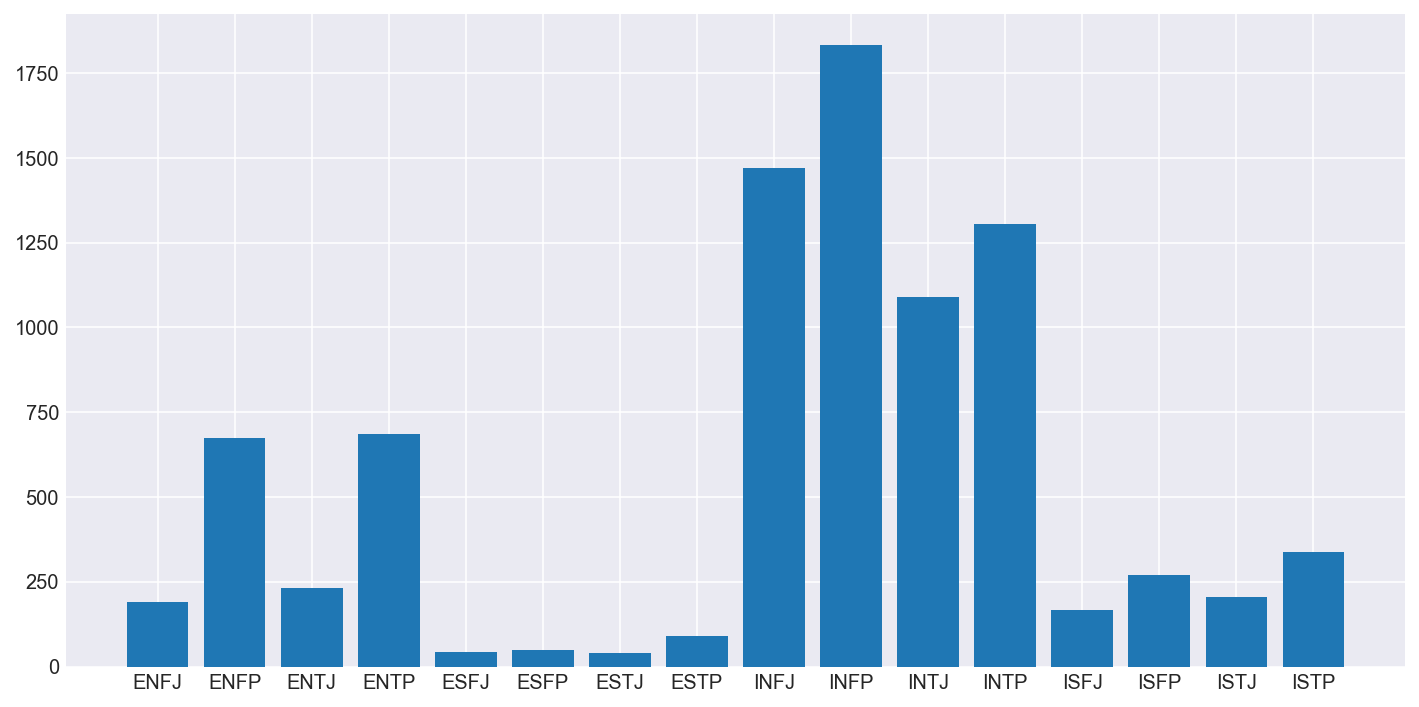

In [6]:
#Cast it here
mbtitypes = mbtitypes_all['type'].value_counts()
plt.figure(figsize=(12,6))
plt.bar(mbtitypes.index, mbtitypes)

In [7]:
#Representation compared to general population
#Here's a dictionary. Good luck to me.
#Source: https://www.careerplanner.com/MB2/TypeInPopulation.cfm

mbtipopdict = {'ISFJ':13.8, 'ESFJ':12.3, 'ISTJ':11.6, 'ISFP':8.8, 'ESTJ':8.7,'ESFP':8.5,'ENFP':8.1,'ISTP':5.4,'INFP':4.4,
              'ESTP':4.3,'INTP':3.3,'ENTP':3.2,'ENFJ':2.5,'INTJ':2.1,'ENTJ':1.8,'INFJ':1.5}
mbtipopdf = pd.DataFrame(data=mbtipopdict.values(), index=mbtipopdict.keys(), columns=['percentage'])
mbtipopdf.sort_values('percentage', ascending=False)

,percentage
ISFJ,13.8
ESFJ,12.3
ISTJ,11.6
ISFP,8.8
ESTJ,8.7
ESFP,8.5
ENFP,8.1
ISTP,5.4
INFP,4.4
ESTP,4.3


In [8]:
mbtipopdf = mbtipopdf.join(mbtitypes)

In [9]:
mbtipopdf['perc_scale'] = mbtipopdf['percentage'] * (mbti.shape[0]/100)
mbtipopdf.head()

,percentage,type,perc_scale
ENFJ,2.5,190,215.0
ESFP,8.5,48,731.0
INFJ,1.5,1470,129.0
ISTJ,11.6,205,997.6
ENTJ,1.8,231,154.8


In [10]:
mbtipopdf = mbtipopdf.sort_values('type', ascending=False).reset_index()
mbtipopdf.rename(columns={'index':'MBTI'}, inplace=True)

In [11]:
mbtipopdf

,MBTI,percentage,type,perc_scale
0,INFP,4.4,1832,378.4
1,INFJ,1.5,1470,129.0
2,INTP,3.3,1304,283.8
3,INTJ,2.1,1091,180.6
4,ENTP,3.2,685,275.2
5,ENFP,8.1,675,696.6
6,ISTP,5.4,337,464.4
7,ISFP,8.8,271,756.8
8,ENTJ,1.8,231,154.8
9,ISTJ,11.6,205,997.6


[Text(0,0,u'INFP'),
 Text(0,0,u'INFJ'),
 Text(0,0,u'INTP'),
 Text(0,0,u'INTJ'),
 Text(0,0,u'ENTP'),
 Text(0,0,u'ENFP'),
 Text(0,0,u'ISTP'),
 Text(0,0,u'ISFP'),
 Text(0,0,u'ENTJ'),
 Text(0,0,u'ISTJ'),
 Text(0,0,u'ENFJ'),
 Text(0,0,u'ISFJ'),
 Text(0,0,u'ESTP'),
 Text(0,0,u'ESFP'),
 Text(0,0,u'ESFJ'),
 Text(0,0,u'ESTJ')]

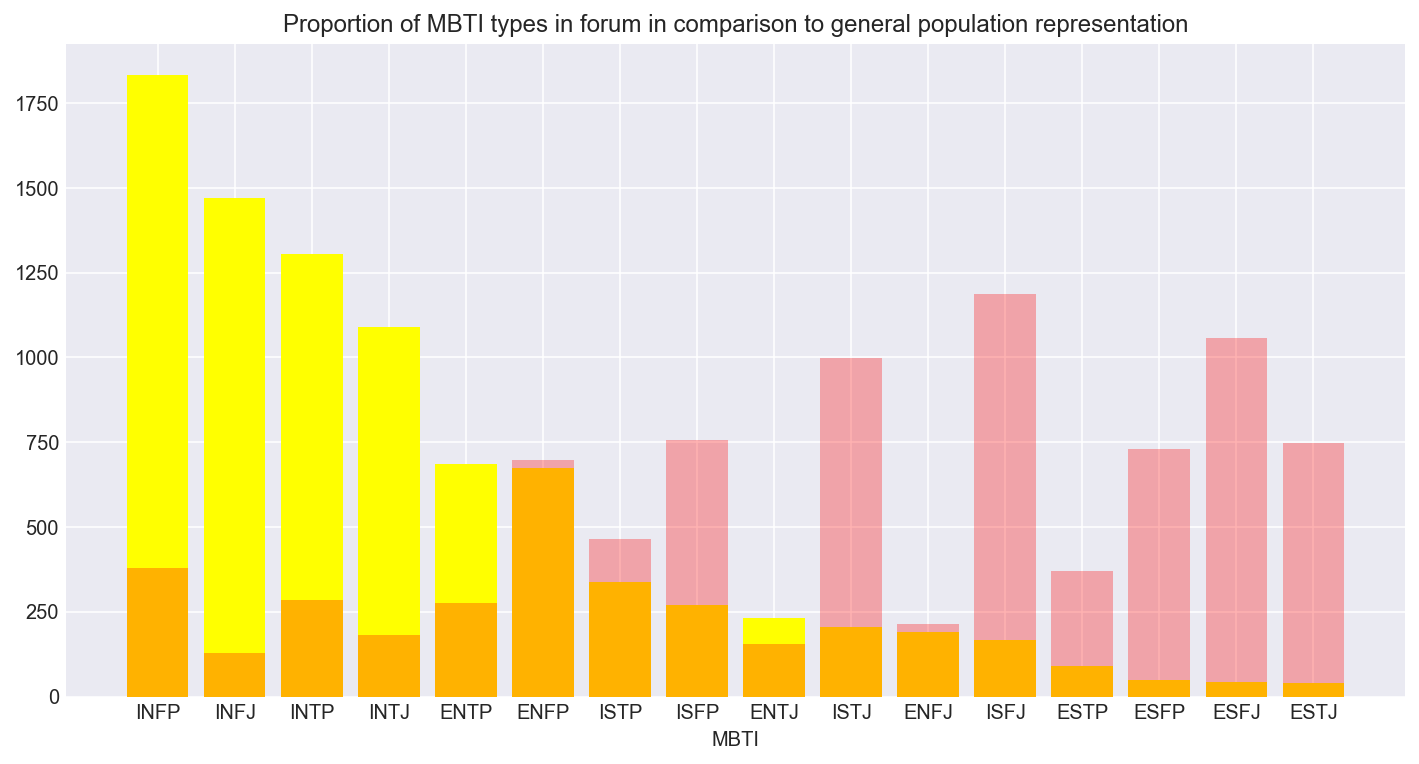

In [12]:
plt.figure(figsize=(12,6))
plt.bar(mbtipopdf.index, mbtipopdf['type'], color='yellow')
plt.bar(mbtipopdf.index, mbtipopdf['perc_scale'], color='red', alpha=0.3)
plt.xlabel('MBTI')
plt.title('Proportion of MBTI types in forum in comparison to general population representation')
ax = plt.gca() # grab the current axis
ax.set_xticks(mbtipopdf.index) # choose which x locations to have ticks
ax.set_xticklabels(mbtipopdf['MBTI']) # set the labels to display at those ticks

Time to unleash imblearn!

View each type individually

In [16]:
mbtitypes_all['is_E'] = mbtitypes_all['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
mbtitypes_all['is_S'] = mbtitypes_all['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
mbtitypes_all['is_T'] = mbtitypes_all['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
mbtitypes_all['is_J'] = mbtitypes_all['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
mbtitypes_all.columns = ['type','is_E','is_S','is_T','is_J']
mbtitypes_all.head()

,type,is_E,is_S,is_T,is_J
0,INFJ,0,0,0,1
1,ENTP,1,0,1,0
2,INTP,0,0,1,0
3,INTJ,0,0,1,1
4,ENTJ,1,0,1,1


In [21]:
ESTJstat = mbtitypes_all.iloc[:,1:].apply(np.sum, axis=0)
ESTJstat

is_E    1999
is_S    1197
is_T    3981
is_J    3434
dtype: int64

([<matplotlib.patches.Wedge at 0x1646ccc0>,
 [Text(0.353528,1.04164,u'J: 39%'), Text(-0.353528,-1.04164,u'P: 60%')])

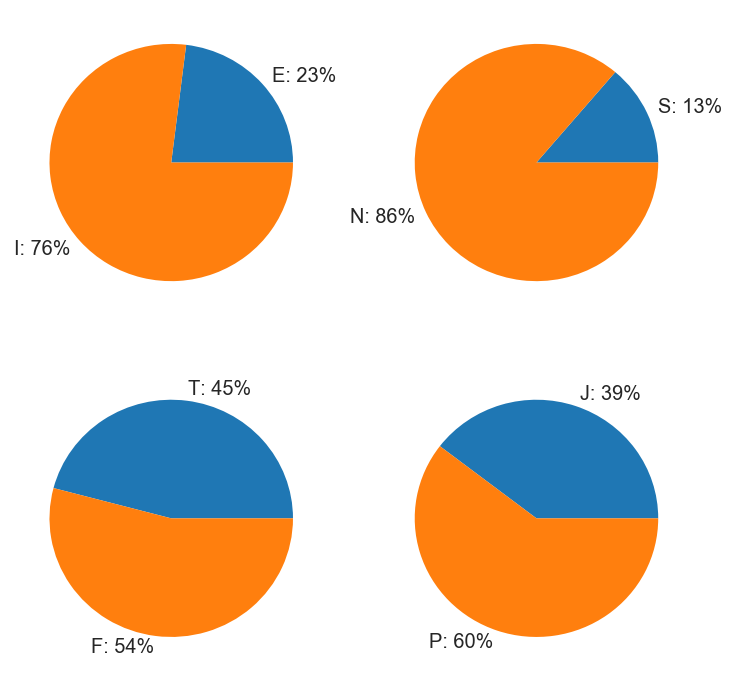

In [25]:
def labie(ind, lab):
    totalno = mbti.shape[0]
    newlab = []
    one = ESTJstat[ind]
    two = totalno - one
    newlab.append(lab[0]+": "+str(int((one/float(totalno))*100))+'%')
    newlab.append(lab[1]+": "+str(int((two/float(totalno))*100))+'%')
    return newlab
    
ESTJstat[0]
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.pie([ESTJstat[0], totalno-ESTJstat[0]], labels=labie(0,['E','I']))
plt.subplot(222)
plt.pie([ESTJstat[1], totalno-ESTJstat[1]], labels=labie(1,['S','N']))
plt.subplot(223)
plt.pie([ESTJstat[2], totalno-ESTJstat[2]], labels=labie(2,['T','F']))
plt.subplot(224)
plt.pie([ESTJstat[3], totalno-ESTJstat[3]], labels=labie(3,['J','P']))

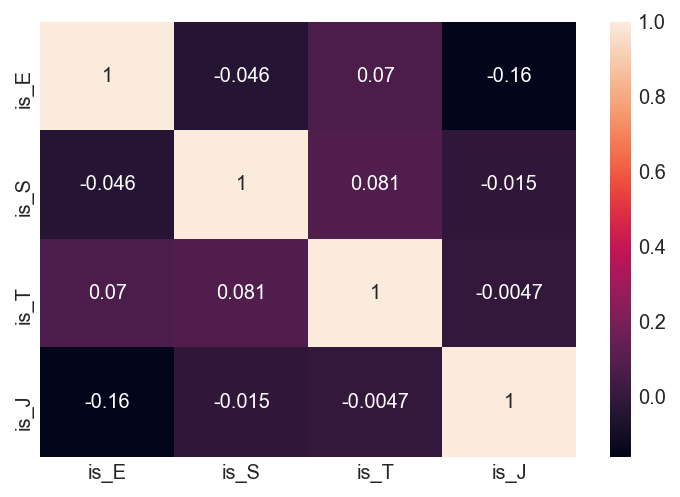

In [30]:
sns.heatmap(mbtitypes_all[['is_E','is_S','is_T','is_J']].corr(), annot=True)

In [42]:
#Do ttest
dfag = pd.DataFrame(columns=['a','b','p-value'
for a in ['is_E','is_S','is_T','is_J']:
    for b in ['is_E','is_S','is_T','is_J']:
        tstat, pval = stats.ttest_rel(mbtitypes_all[a], mbtitypes_all[b])
        if a == b:
            continue
        dfag = dfag.append({'a':a,'b':b,'p-value':pval}, ignore_index=True)


In [43]:
dfag

,a,b,p-value
0,is_E,is_S,2.661569e-53
1,is_E,is_T,2.617815e-235
2,is_E,is_J,6.491791e-106
3,is_S,is_E,2.661569e-53
4,is_S,is_T,0.000000e+00
5,is_S,is_J,0.000000e+00
6,is_T,is_E,2.617815e-235
7,is_T,is_S,0.000000e+00
8,is_T,is_J,5.551196e-17
9,is_J,is_E,6.491791e-106
